# Notebook to train the model on the EMOVO dataset

In [1]:
# import libraries and set random seed for reproducibility
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import shutil
import gc

from matplotlib import pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [2]:
# allow memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# load the dataframe containing the metadata
train_data = pd.read_csv('documents' +os.sep+ 'emovo.csv')

train_data.head()

,file_name,classID,class
0,images\dis-f1-b1.wav.png,0,disgusto
1,images\dis-f1-b2.wav.png,0,disgusto
2,images\dis-f1-b3.wav.png,0,disgusto
3,images\dis-f1-d1.wav.png,0,disgusto
4,images\dis-f1-d2.wav.png,0,disgusto


## Hyperparameters

In [4]:
# Define the number of folds
k = 5

# Define the number of epochs for each fold
epochs = 50

# Define the batch size. It depends on your GPU
batch_size = 8

## Parameters

In [5]:
# Define the target image size
height = 450
width = 450
channels = 3
target_size = (height, width)
target_shape = (height, width, channels)

# Define the class mode
class_mode = 'categorical'

# Define the data generator for data augmentation
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# Define the list of all image labels
labels = train_data['class'].unique()

# Convert the labels to a numpy array
labels = np.array(labels)

# Define the number of classes
num_classes = len(labels)
print('Number of classes:', num_classes)

Number of classes: 7


## Model

In [6]:
# Define and compile the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=target_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

tf.keras.backend.clear_session()
gc.collect()
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 446, 446, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 223, 223, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 219, 219, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 109, 109, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 53, 53, 128)      0

## Train the model with k-fold cross validation

In [7]:
# Define the k-cross fold cross-validator
kf = KFold(n_splits=k, shuffle=True)

# Define a dictionary to store the history of the model for each fold
fold2history = {}

tf.config.run_functions_eagerly(False)

# Loop over the folds
for fold, (train_index, test_index) in enumerate(kf.split(train_data)):
        histories = []
        # Define the model
        model = create_model()
        
        # Define the training and validation data for this fold
        train_df = train_data.iloc[train_index]
        test_df = train_data.iloc[test_index]

        # split the data into train and test sets
        train, val = train_test_split(train_df, test_size=0.15, shuffle=True)

        # Define the data generator for training data
        train_datagen = datagen.flow_from_dataframe(
                train,
                directory=None,
                x_col='file_name',
                y_col='class',
                target_size=target_size,
                batch_size=batch_size,
                class_mode=class_mode)

        # Define the data generator for validation data
        val_datagen = datagen.flow_from_dataframe(
                val,
                directory=None,
                x_col='file_name',
                y_col='class',
                target_size=target_size,
                batch_size=batch_size,
                class_mode=class_mode)
        
        # Define the data generator for test data
        test_datagen = datagen.flow_from_dataframe(
                test_df,
                directory=None,
                x_col='file_name',
                y_col='class',
                target_size=target_size,
                batch_size=batch_size,
                class_mode=class_mode)

        clear_output(wait=True)
        print(f'Fold {fold+1}/{k}')
        # Train the model on the training data
        history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, verbose=1)
        histories.append(history.history)
        
        # Evaluate the model on the validation data
        loss, accuracy = model.evaluate(test_datagen)
        print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')
        
        # Save the history of the model for each fold
        fold2history[fold] = (histories, loss, accuracy)

        # Save the model for each fold
        model.save('models' +os.sep+ f'fold{fold}_model.h5')

        # Delete the model to free memory on GPU
        tf.compat.v1.reset_default_graph()
        tf.keras.backend.clear_session()
        gc.collect()
        del model, history, histories, train_datagen, val_datagen, test_datagen, train_df, test_df, train, val

Fold 5/5
Epoch 1/50
50/50 [==============================] - 14s 276ms/step - loss: 0.5174 - accuracy: 0.1600 - val_loss: 0.4118 - val_accuracy: 0.1268
Epoch 2/50
50/50 [==============================] - 14s 285ms/step - loss: 0.4142 - accuracy: 0.1575 - val_loss: 0.4094 - val_accuracy: 0.2394
Epoch 3/50
50/50 [==============================] - 14s 273ms/step - loss: 0.4126 - accuracy: 0.1600 - val_loss: 0.4060 - val_accuracy: 0.1831
Epoch 4/50
50/50 [==============================] - 14s 287ms/step - loss: 0.4066 - accuracy: 0.1550 - val_loss: 0.4063 - val_accuracy: 0.1549
Epoch 5/50
50/50 [==============================] - 14s 272ms/step - loss: 0.3913 - accuracy: 0.2150 - val_loss: 0.3802 - val_accuracy: 0.3099
Epoch 6/50
50/50 [==============================] - 14s 286ms/step - loss: 0.3888 - accuracy: 0.2475 - val_loss: 0.3780 - val_accuracy: 0.2676
Epoch 7/50
50/50 [==============================] - 14s 274ms/step - loss: 0.3712 - accuracy: 0.3300 - val_loss: 0.3751 - val_accurac

## Results and plots

In [8]:
history = []
test_loss = []
test_accuracy = []

for fold in fold2history.keys():
    history.extend(fold2history[fold][0][0]['val_accuracy'])
    test_loss.append(fold2history[fold][1])
    test_accuracy.append(fold2history[fold][2])

In [9]:
# get the fold with the highest accuracy
best_fold = np.argmax(test_accuracy)

# copy the model to the best_model.h5 file
shutil.copyfile('models'+ os.sep +f'fold{best_fold}_model.h5', 'models'+ os.sep +'best_model.h5')

print(f'Best fold: {best_fold}, Test loss: {test_loss[best_fold-1]:.4f}, Test accuracy: {test_accuracy[best_fold-1]:.4f}')

Best fold: 3, Test loss: 0.7383, Test accuracy: 0.4915


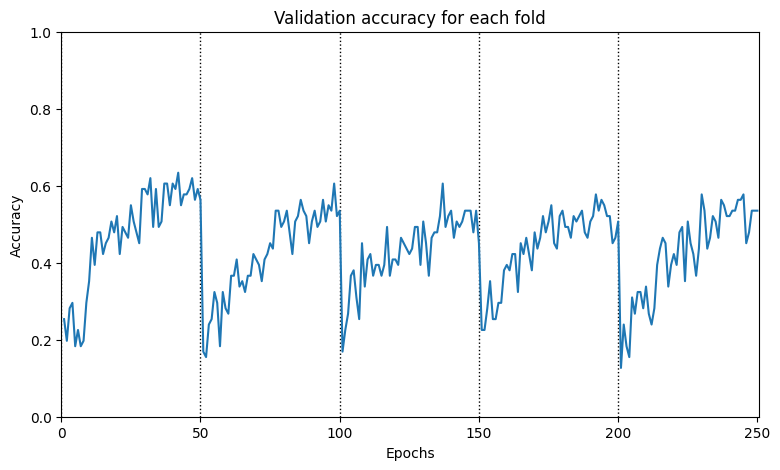

In [10]:
# validation accuracy for each fold
plt.figure(figsize=(9, 5))
plt.title('Validation accuracy for each fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([0.5, len(history)+0.5, 0, 1])

# draw dot lines for each fold
for i in range(k):
    plt.plot([i*epochs, i*epochs], [0, 1], 'k:', linewidth=1)
    
plt.xticks(np.arange(0, len(history)+1, epochs))
plt.plot(np.arange(1, len(history)+1), history, label='val_accuracy')

plt.show()

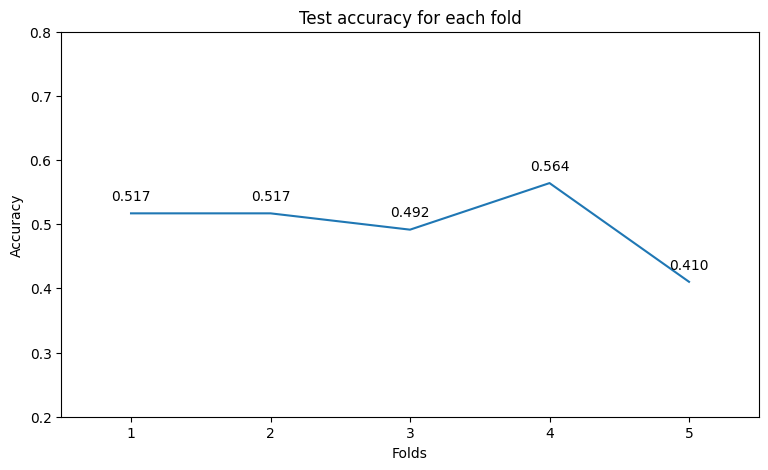

In [11]:
# test accuracy plot
plt.figure(figsize=(9, 5))
plt.title('Test accuracy for each fold')
plt.xlabel('Folds')
plt.ylabel('Accuracy')

# set axis limits to show the plot clearly
plt.axis([0.5, len(test_accuracy)+0.5, 0.2, 0.8])

for i, v in enumerate(test_accuracy):
    plt.text(i+1, v+0.02, "%.3f" %v, ha="center")
 
plt.xticks(np.arange(1, len(test_accuracy)+1, 1))   
plt.plot(np.arange(1, len(test_accuracy)+1), test_accuracy, label='test accuracy')

plt.show()

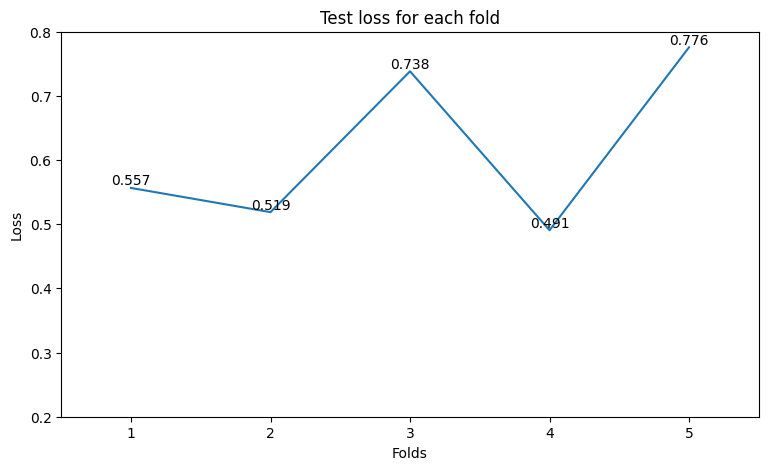

In [12]:
# test loss plot
plt.figure(figsize=(9, 5))
plt.title('Test loss for each fold')
plt.xlabel('Folds')
plt.ylabel('Loss')

# set axis limits to show the plot clearly
plt.axis([0.5, len(test_loss)+0.5, 0.2, 0.8])

for i, v in enumerate(test_loss):
    plt.text(i+1, v+0.005, "%.3f" %v, ha="center")
 
plt.xticks(np.arange(1, len(test_loss)+1, 1))   
plt.plot(np.arange(1, len(test_loss)+1), test_loss, label='test loss')

plt.show()